In [1]:
import cv2
import numpy as np
import os
%matplotlib inline
from matplotlib import pyplot as plt

### 截取照片臉部的部分

In [26]:
# https://medium.com/@somaniswastik/face-recognition-using-tensorflow-pre-trained-model-opencv-91184efa4aaf
# 截取照片臉部的部分

def dataset():
    images = []
    labels = []
    labels_dic = {}
    people = [person for person in os.listdir ("data/dataset/")]

    for i, person in enumerate(people): #people
            if person == '.DS_Store':
                continue
            else:
                labels_dic[i] = person
#                 print(person)
    #             if i % 100 == 0:
    #                 print(labels_dic[i])           
                images.append(cv2.imread("data/dataset/" + person))
                labels.append(person)
       
    return (images, np.array(labels), labels_dic)

images, labels, labels_dic = dataset()
# print(len(images))


class FaceDetector(object):
    def __init__(self, xml_path):
        self.classifier = cv2.CascadeClassifier(xml_path)
    
    def detect(self, image, biggest_only=True):
        scale_factor = 1.2
        min_neighbors = 5
        min_size = (30, 30)
        biggest_only = True
        faces_coord = self.classifier.detectMultiScale(image,
                                                       scaleFactor=scale_factor,
                                                       minNeighbors=min_neighbors,
                                                       minSize=min_size,
                                                       flags=cv2.CASCADE_SCALE_IMAGE)
        return faces_coord

    
def cut_faces(image, faces_coord):
    faces = []
    
    for (x, y, w, h) in faces_coord:
        w_rm = int(0.3 * w / 2)
        faces.append(image[y: y + h, x + w_rm: x + w - w_rm])
         
    return faces

def resize(images, size=(224, 224)):
    images_norm = []
    for image in images:
        if image.shape < size:
            image_norm = cv2.resize(image, size, 
                                    interpolation=cv2.INTER_AREA)
        else:
            image_norm = cv2.resize(image, size, 
                                    interpolation=cv2.INTER_CUBIC)
        images_norm.append(image_norm)

    return images_norm



def normalize_faces(image, faces_coord):

    faces = cut_faces(image, faces_coord)
    faces = resize(faces)
    
    return faces

for i, image in enumerate(images):
    detector = FaceDetector("/Users/owner/opt/anaconda3/lib/python3.7/site-packages/cv2/data/haarcascade_frontalface_default.xml")
    faces_coord = detector.detect(image, True)
    faces = normalize_faces(image ,faces_coord)
#     faces[0] = cv2.cvtColor(faces[0], cv2.COLOR_BGR2RGB)
#     plt.imshow(faces[0])
#     plt.show()
    
    for j, face in enumerate(faces):
        a = labels[i].strip(".png")
        cv2.imwrite(f'data/cut_dataset/{a}.jpeg', faces[j])
    
        
# 沒有cut 完全部的資料

pip install fastai

In [27]:
# create class folders
for i in range(150, 200, 5):
    os.mkdir(f"data/organized_cut_dataset/{i+1}-{i+5}")

### 將資料分類

In [12]:
# 將資料分類
import pandas as pd 
data = pd.read_csv("data/info.csv") 
data1 = data[data['height'] != "N"] # 將height為'N'的拿掉
data1['height'] = pd.to_numeric(data1['height']) 

/Users/owner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
data1.head(20)

,index,name,height,weight
0,0,陈晓东,178,65
1,1,海顿,178,65
2,2,杨烁,184,75
3,3,马思纯,171,50
4,4,陶昕然,160,42
5,5,宋小莹,160,49
6,6,刘立,180,65
7,7,李小冉,160,48
8,8,张国立,178,70
9,9,杨幂,160,45


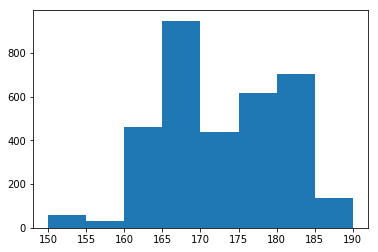

In [14]:
plt.hist(data1['height'],bins=[150,155,160,165,170,175,180,185,190])
plt.show()

In [33]:
len(data1[data1['index'] == 12])

1

### 將照片分類進class folders

In [34]:
# 將照片分類進class folders
from shutil import copyfile
list0 = os.listdir('data/cut_dataset') # dir is your directory path
list0.remove('.DS_Store')
for i in list0:
    if len(data1[data1['index'] == int(i.strip(".jpeg"))]) != 0:
        height = data1[data1['index'] == int(i.strip(".jpeg"))]['height'].values[0]
        for j in range(150, 200, 5):
                if (height >= j+1) and (height <= j+5):
                    copyfile(f"data/cut_dataset/{i}", f"data/organized_cut_dataset/{j+1}-{j+5}/{i}")
    else:
        continue


### 利用fastai做影像識別

In [2]:
# 利用fastai做影像識別
# https://zhuanlan.zhihu.com/p/69407443
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
path = 'data/organized_cut_dataset'
tfms = get_transforms(do_flip=False) #轉換照片成電腦可以解讀的格式
data = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=tfms, size=224).normalize(imagenet_stats)

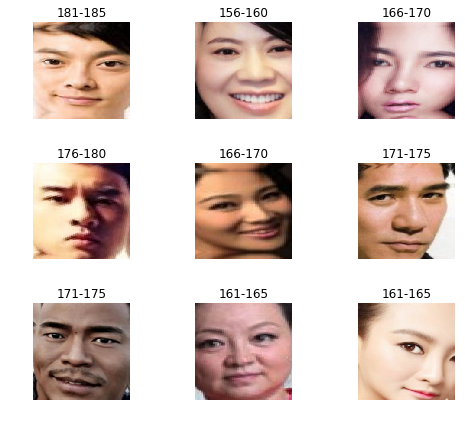

In [4]:
data.show_batch(rows=3, figsize=(7,6))

In [5]:
print(data.classes)

['151-155', '156-160', '161-165', '166-170', '171-175', '176-180', '181-185', '186-190', '191-195']


In [6]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [7]:
# train model 
# get loss and accuracy
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,3.127287,2.040995,0.325455,19:21
1,2.688695,1.943709,0.334545,29:55
2,2.397035,1.802098,0.343636,32:11
3,2.071976,1.683209,0.367273,32:18
4,1.845597,1.567922,0.361818,55:35
5,1.663379,1.522495,0.376364,32:29
6,1.519118,1.471137,0.423636,32:35
7,1.443218,1.460530,0.416364,32:37
8,1.369723,1.456234,0.414545,33:01
9,1.319894,1.451735,0.421818,33:29


In [8]:
learn.save('/Users/owner/Desktop/Github/School_project/Deep_Learning/final_project/stage1')

In [21]:
learn.load('model')

Learner(data=ImageDataBunch;

Train: LabelList (2580 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
161-165,161-165,161-165,161-165,161-165
Path: data/organized_cut_dataset;

Valid: LabelList (645 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
171-175,181-185,171-175,181-185,161-165
Path: data/organized_cut_dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(6

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

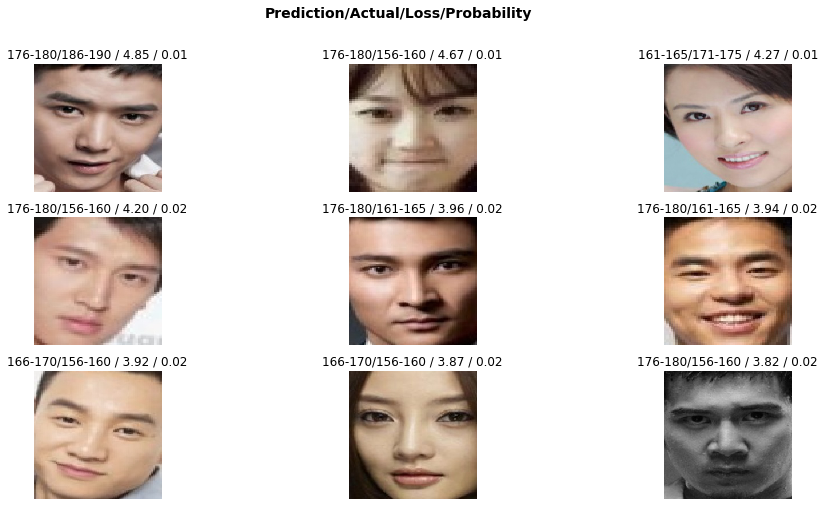

In [16]:
interp.plot_top_losses(9, figsize=(16,8))

### Confusion Matrix

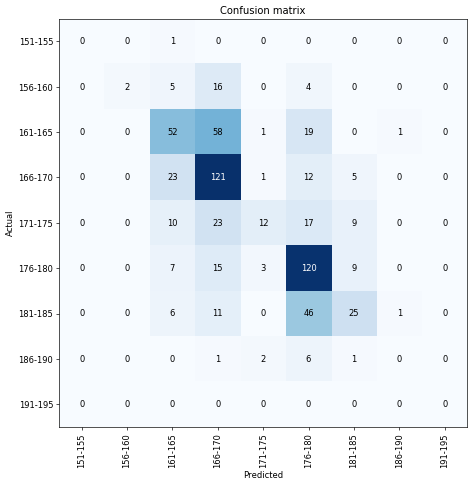

In [17]:
interp.plot_confusion_matrix(figsize=(10,8), dpi=60)

### 最容易搞錯的幾個類別

In [18]:
interp.most_confused(min_val=2)

[('161-165', '166-170', 58),
 ('181-185', '176-180', 46),
 ('166-170', '161-165', 23),
 ('171-175', '166-170', 23),
 ('161-165', '176-180', 19),
 ('171-175', '176-180', 17),
 ('156-160', '166-170', 16),
 ('176-180', '166-170', 15),
 ('166-170', '176-180', 12),
 ('181-185', '166-170', 11),
 ('171-175', '161-165', 10),
 ('171-175', '181-185', 9),
 ('176-180', '181-185', 9),
 ('176-180', '161-165', 7),
 ('181-185', '161-165', 6),
 ('186-190', '176-180', 6),
 ('156-160', '161-165', 5),
 ('166-170', '181-185', 5),
 ('156-160', '176-180', 4),
 ('176-180', '171-175', 3),
 ('186-190', '171-175', 2)]

### Insight

* 預測率大約42%
* 資料不是太平衡，要再調整
* 是否臉跟身高的關係就是不顯著？